# FWI modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering

In [2]:
M = load("model_custom_fwi_result_low_f.jld");

In [3]:
model = Model(M["n"], M["d"], M["o"], M["m"])
model0 = Model(M["n"], M["d"], M["o"], M["m0"])
dm = vec(M["dm"]);

In [4]:
vmin = ones(Float32,model0.n) .* 1.5f0
vmax = ones(Float32,model0.n) .* 3.0f0;
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
block = segy_read("model_custom_high_f.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=4763124, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geouser/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


In [6]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.015f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


In [7]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [8]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [9]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [10]:
# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end

FWI iteration no: 1; function value: 6385.401
(α, misfit) = 

Building forward operator
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.02 s
Building adjoint born operator
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 

(0.1f0, 6488.54296875)


Building forward operator
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.04981918829643327, 2304.5751953125)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


2; function value: 2531.9175


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 232464.734375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 4859.037109375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.002561465091673757, 2272.0830078125)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


3; function value: 2255.114


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 3706.8623046875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.04667153506135858, 1725.8978271484375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s


FWI iteration no: 4; function value: 1746.3527
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 69683.1875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010454013911000442, 1392.236083984375)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


5; function value: 1341.3313


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 4643.17529296875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.04165212172820053, 1758.514404296875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.017158386024335025, 1078.9659423828125)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


6; function value: 1141.4407


Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 155015.53125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 2676.875244140625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.0022884828568948525, 982.1470947265625)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


7; function value: 944.8672


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 19733.70703125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.01679219840916861, 1075.5667724609375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.007491351181434281, 820.3939819335938)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


8; function value: 764.9812


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 319973.5)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 6506.12451171875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 739.02294921875)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


9; function value: 755.4334


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 998.462646484375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.048563716127597224, 614.172607421875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 10; function value: 681.5921
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 137471.484375)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 2156.072021484375)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.0024511649312423693, 493.9772033691406)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 11; function value: 447.93845
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 21561.724609375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.01618729960727368, 768.8126831054688)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.00647554171673607, 375.7176818847656)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 12; function value: 434.90283
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 313319.0625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 5811.0634765625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.0010000000149011613, 418.42010498046875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 13; function value: 349.27942
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 534.736572265625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.04884022138438295, 342.9653015136719)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


14; function value: 396.56125


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 130008.1953125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


(0.010000000149011612, 1946.8096923828125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.0017847915073566298, 315.14739990234375)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


15; function value: 356.90765


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 24569.6875)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.01206061689702504, 625.2355346679688)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.004511880270239557, 320.7953796386719)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


16; function value: 262.41568


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 412435.09375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 8756.470703125)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 289.22222900390625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.00037200797011640164, 247.5891876220703)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 17; function value: 292.30408
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 14105.1767578125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.01321629222349617, 774.27978515625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.0035787761358924666, 310.82415771484375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0015016810060451875, 275.0895690917969)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


18; function value: 256.8232


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 281859.4375)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 4723.71484375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.0010000000149011613, 267.9501037597656)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.0003887280449250656, 249.2525634765625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


FWI iteration no: 19; function value: 247.87445
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 15818.25390625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 338.79974365234375)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.003575260795725848, 234.0951385498047)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 20; function value: 232.20276
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 209713.578125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 3375.594970703125)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.0010000000149011613, 230.7359161376953)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 21; function value: 231.27856
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 367.00567626953125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.048874526540922156, 216.9389190673828)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


22; function value: 238.00436


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 447211.03125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 10610.958984375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 252.45420837402344)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.00044213152704589506, 213.8040313720703)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 23; function value: 214.58525
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 3602.804443359375)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.02706093268943045, 566.132568359375)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.009169975620421981, 238.326171875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0038864395247620465, 173.60826110839844)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


24; function value: 182.33334


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 89644.1953125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 1663.582275390625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 168.6049041748047)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


25; function value: 143.45088


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 920.5765991210938)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.03435548254124096, 202.81954956054688)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.014046115249330858, 136.49034118652344)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


26; function value: 143.73833


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 335987.6875)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


(0.010000000149011612, 6642.8017578125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 176.78952026367188)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.00028946764345474593, 137.865478515625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 27; function value: 149.08926
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 18256.869140625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 279.40936279296875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


(0.0031752627442505187, 138.84519958496094)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 28; function value: 113.488106
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 62088.953125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 707.4517822265625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.001435160534540985, 104.32677459716797)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 29; function value: 105.22219
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 31323.361328125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 441.6319885253906)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.0019280395713673524, 106.41980743408203)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0009039466538832689, 100.16426086425781)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


30; function value: 130.6749


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 320648.4375)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 4196.6103515625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0010000000149011613, 157.65904235839844)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.00024293031123929462, 128.11456298828125)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


In [11]:
fwi = sqrt.(1f0./adjoint(model0.m)).data;
v0 = sqrt.(1f0./M["m0"])';
v = sqrt.(1f0./model.m)'.data;

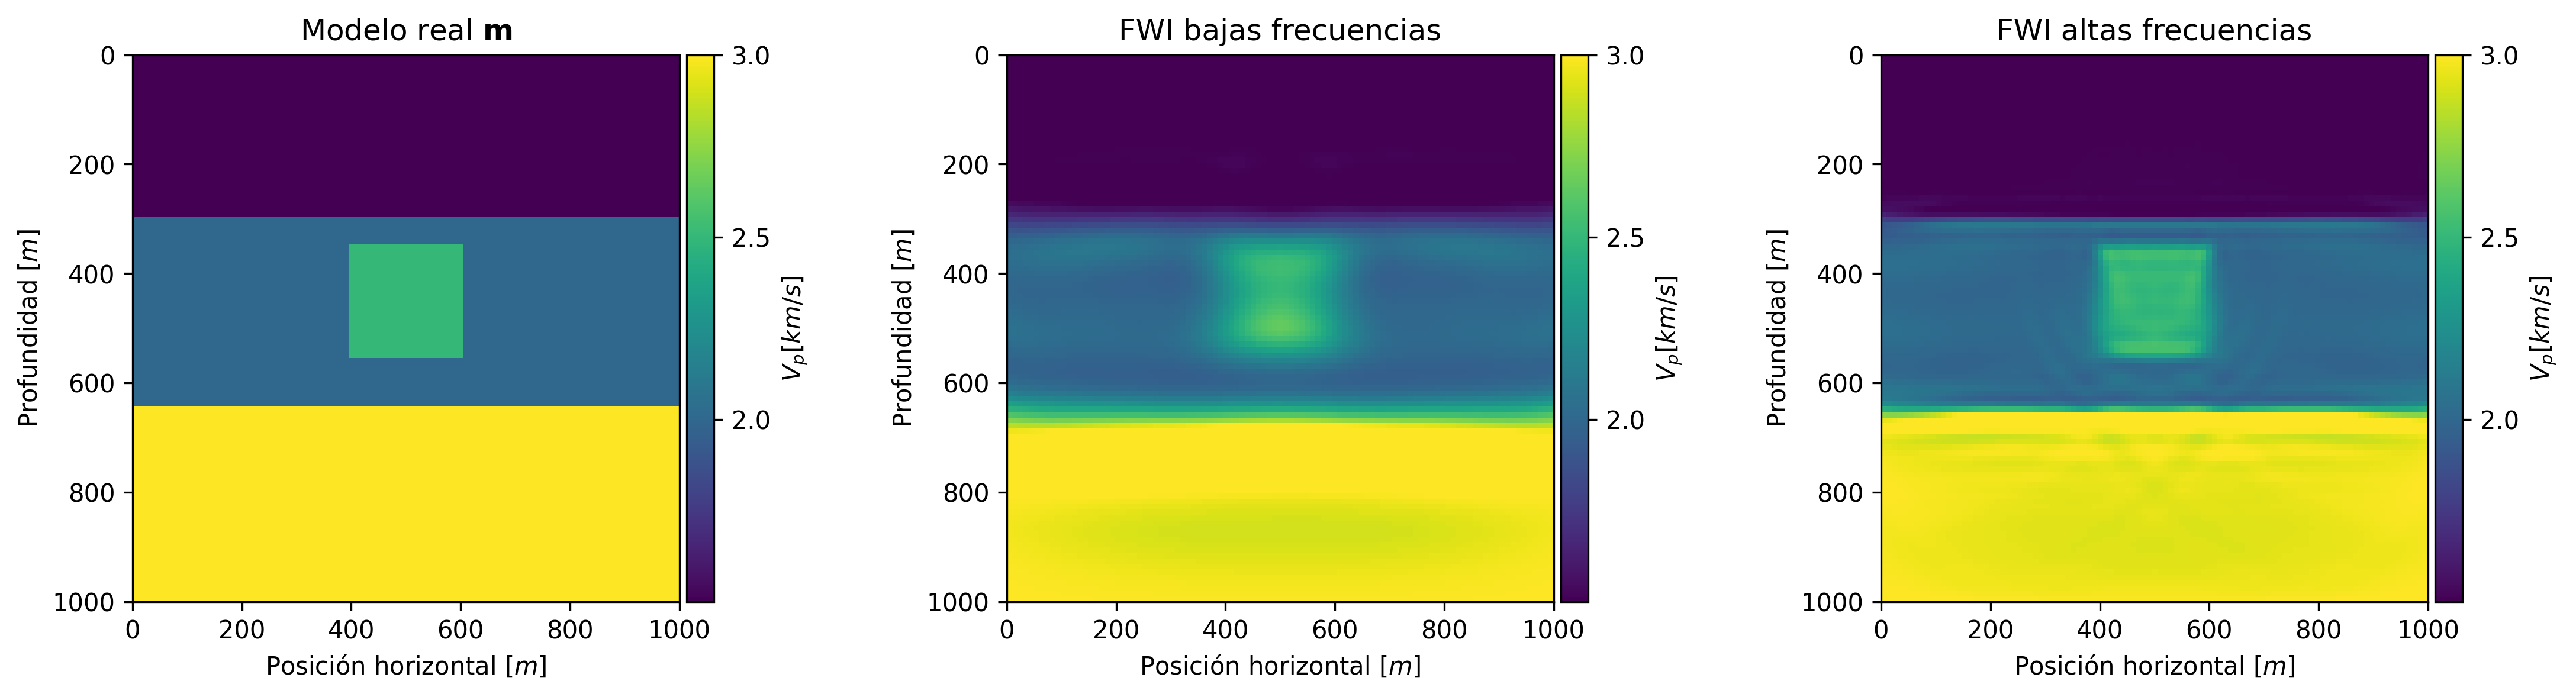

In [23]:
fig=figure(figsize=(18,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI bajas frecuencias")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI altas frecuencias")
display(fig)

In [18]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.010867073
El error cuadrático medio de FWI es: 0.0050896695


In [19]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 2.2057493
Porcentaje de error (FWI): 1.5428457


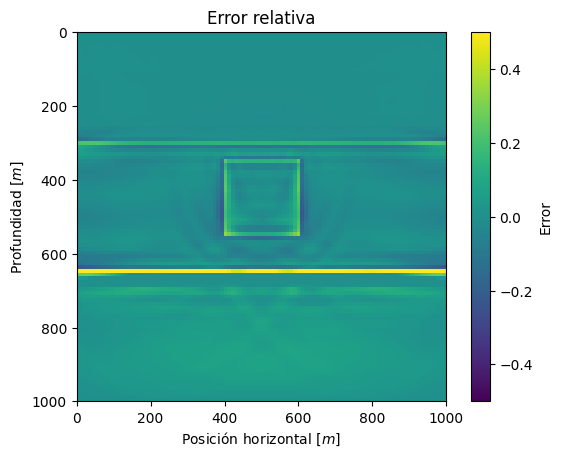

In [20]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model.n[1]-1)*model.d[1], (model.n[2]-1)*model.d[2], 0], vmin=-0.5, vmax=0.5)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

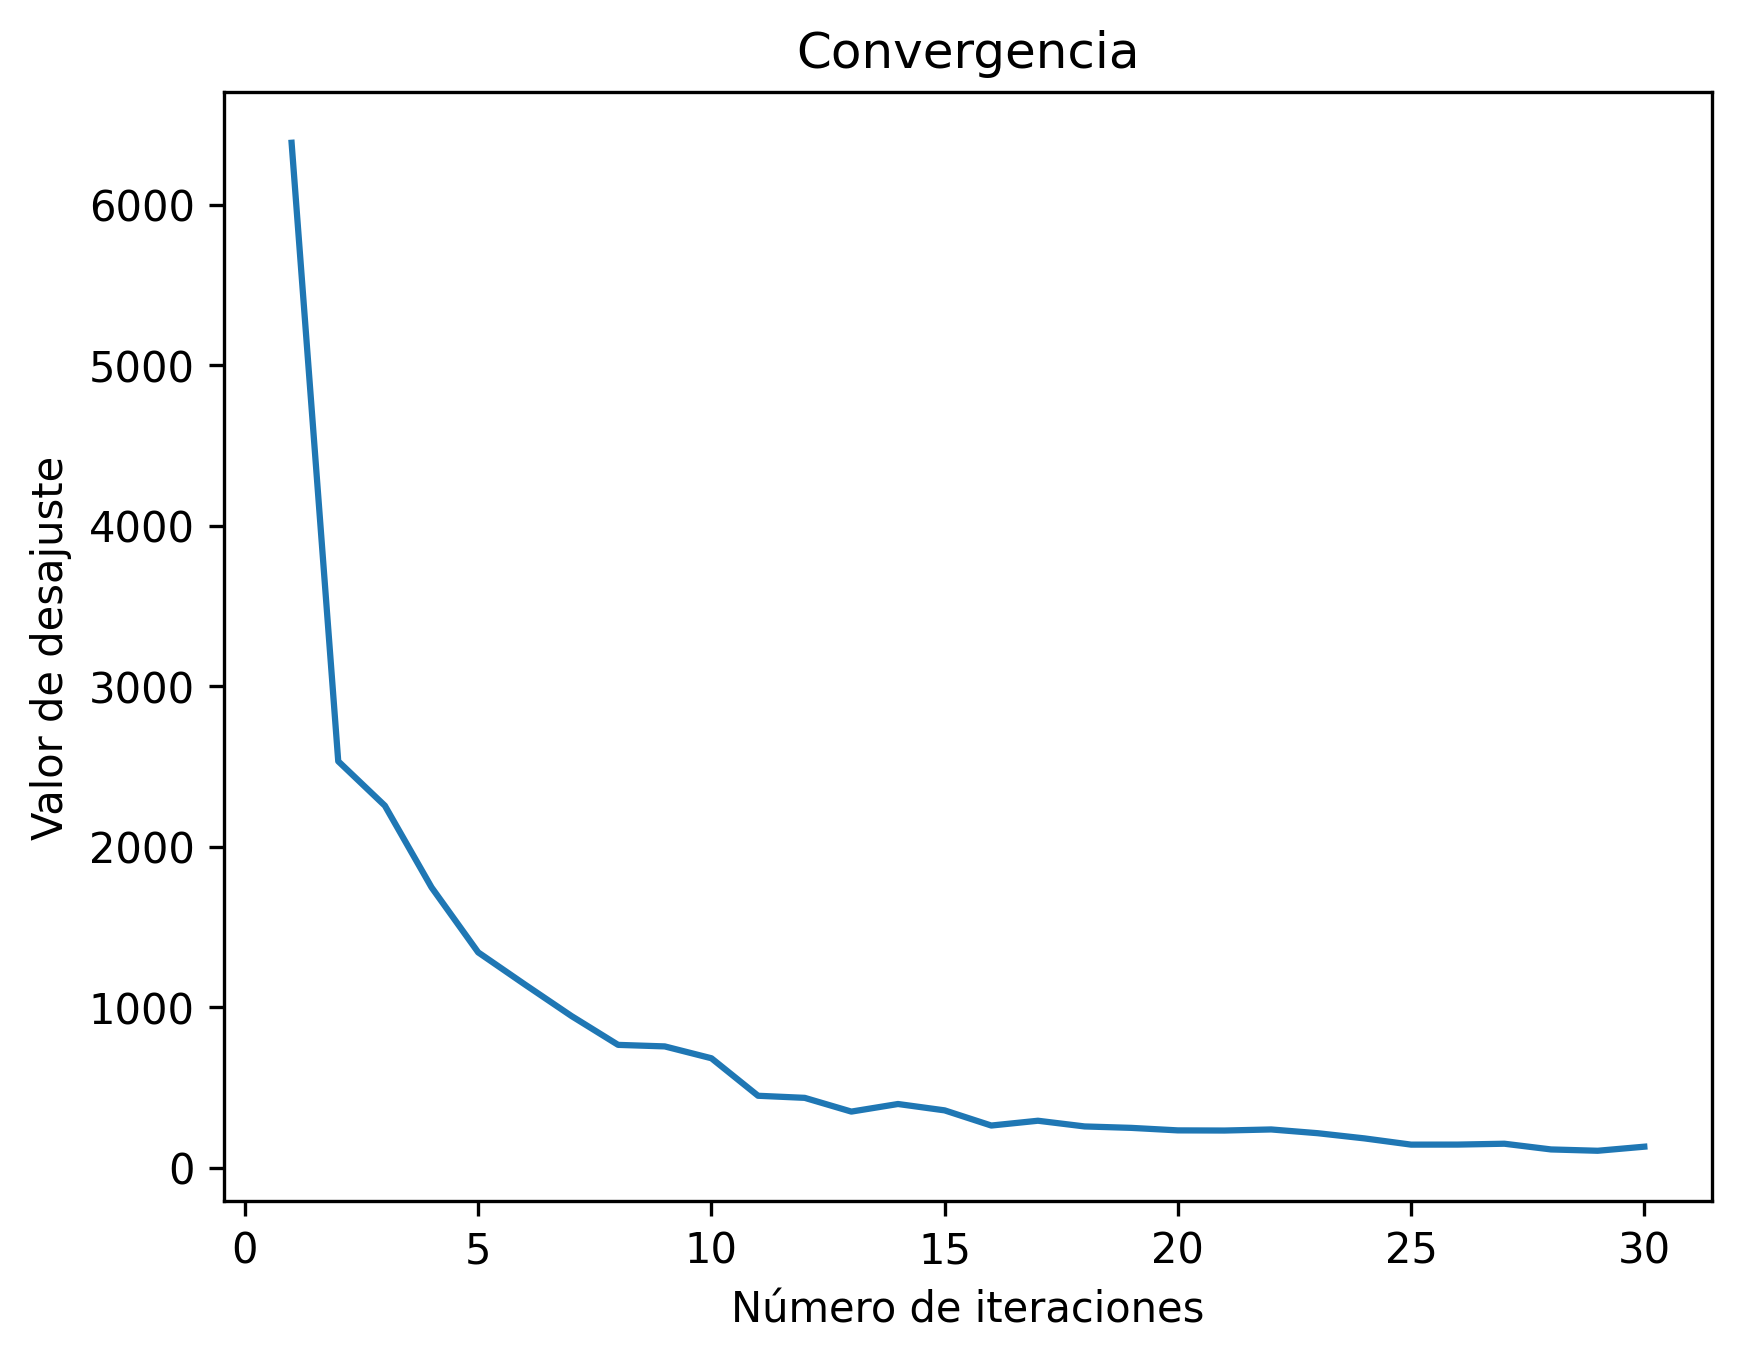

In [21]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [24]:
save("model_custom_fwi_result_high_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)